In [13]:
# fix annoying bug
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [14]:
import torch
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
print(f"Using device: {device}")

Using device: cuda


In [15]:
cuda_id = torch.cuda.current_device()
torch.cuda.get_device_name(cuda_id)

'NVIDIA GeForce GTX 1070 Ti'

In [16]:
data_transform = transform=torchvision.transforms.Compose([
        ToTensor(),
        Lambda(lambda x: (x * 2) - 1) # [0,1] -> [-1,1]
    ])
training_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=data_transform
)
test_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=data_transform
)

Files already downloaded and verified
Files already downloaded and verified


In [17]:
IMAGE_SHAPE = torch.tensor(training_data[0][0].shape)
print(IMAGE_SHAPE)

tensor([ 3, 32, 32])


In [18]:
len(training_data), len(test_data)

(50000, 10000)

In [19]:
batch_size = 64
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

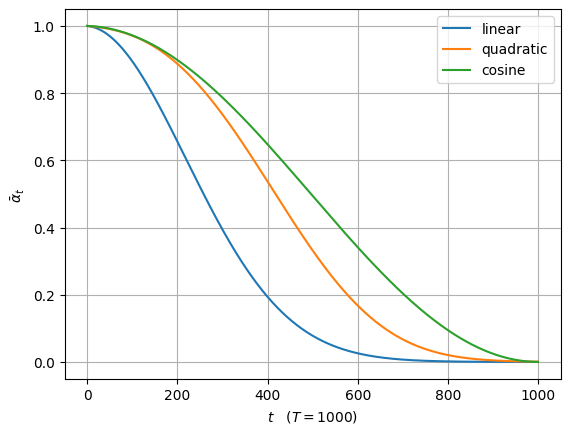

In [20]:
def linear_schedule(T):
    beta = torch.linspace(1e-4,0.02,T).to(device)
    alpha = 1 - beta
    alpha_bar = torch.cumprod(alpha, dim=0)
    return beta,alpha,alpha_bar

def quadratic_schedule(T):
    beta = torch.linspace(1e-4**0.5, 0.02**0.5, T,device=device)**2
    alpha = 1 - beta
    alpha_bar = torch.cumprod(alpha, dim=0)
    return beta,alpha,alpha_bar

def cosine_schedule(T):
    s = 0.008
    f = lambda t: torch.cos( (t/T + s)/(1+s) * torch.pi/2 ) ** 2
    ts = torch.arange(0,T,1,device=device)
    alpha_bar = f(ts) / f(ts[0])

    # alpha_bar = torch.clip(alpha_bar,min=0.0,max=0.999)
    alpha = torch.zeros(T,device=device)
    alpha[0] = alpha_bar[0]
    alpha[1:] = alpha_bar[1:]/alpha_bar[:-1]
    beta = torch.clip(1 - alpha,min=0.001,max=0.999)
    alpha = 1 - beta

    return beta,alpha,alpha_bar

T = 1000
beta,alpha,alpha_bar = linear_schedule(T)
plt.plot(alpha_bar.cpu().numpy(), label='linear')

beta,alpha,alpha_bar = quadratic_schedule(T)
plt.plot(alpha_bar.cpu().numpy(), label='quadratic')

beta,alpha,alpha_bar = cosine_schedule(T)
plt.plot(alpha_bar.cpu().numpy(), label='cosine')

plt.ylabel(r'$\bar{\alpha}_t$')
plt.xlabel(r'$t$   $(T=1000)$')
plt.legend()
plt.grid(True)
plt.show()

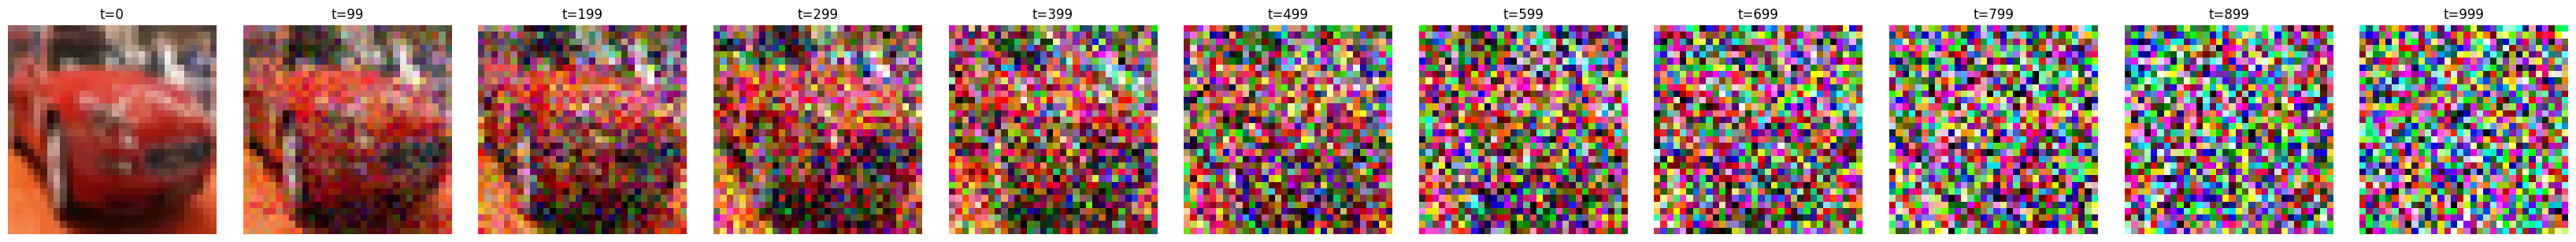

In [ ]:
def forward_diffusion(x0, t):
    if not torch.is_tensor(t):
        t = torch.tensor(t)
    if t.dim() == 0:
        t = t.unsqueeze(0)
    
    t = t[...,None,None].to(device)
    eps = torch.normal(mean=0, std=torch.ones(x0.shape)).to(device)
    xt = alpha_bar[t]**0.5 * x0 + (1 - alpha_bar[t])**0.5 * eps
    return xt, eps

def viz_forward_process(x0_index,num_im=9):
    ts = np.linspace(0,T-1,num=num_im,dtype=int)
    x0 = training_data[x0_index][0].to(device)

    fig, ax = plt.subplots(1, num_im, figsize=(3*num_im, 3))
    for i,t in enumerate(ts):
        xt,eps = forward_diffusion(x0,t)
        # print(xt.cpu().squeeze())

        xt_image = xt.cpu().squeeze().permute(1, 2, 0)
        xt_image = torch.clamp(xt_image, min=-1.0, max=1.0)
        xt_image = (xt_image + 1.0) / 2.0
        ax[i].imshow(xt_image)
        ax[i].axis('off')
        ax[i].set_title(f"t={t}")
    
    plt.tight_layout()
    plt.show()

viz_forward_process(x0_index=5,num_im=11)

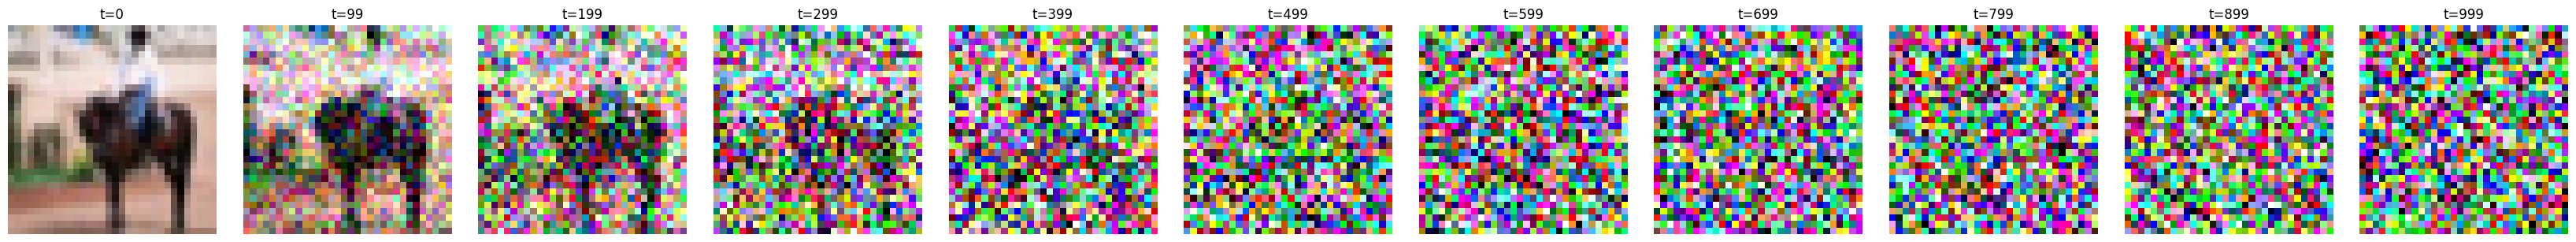

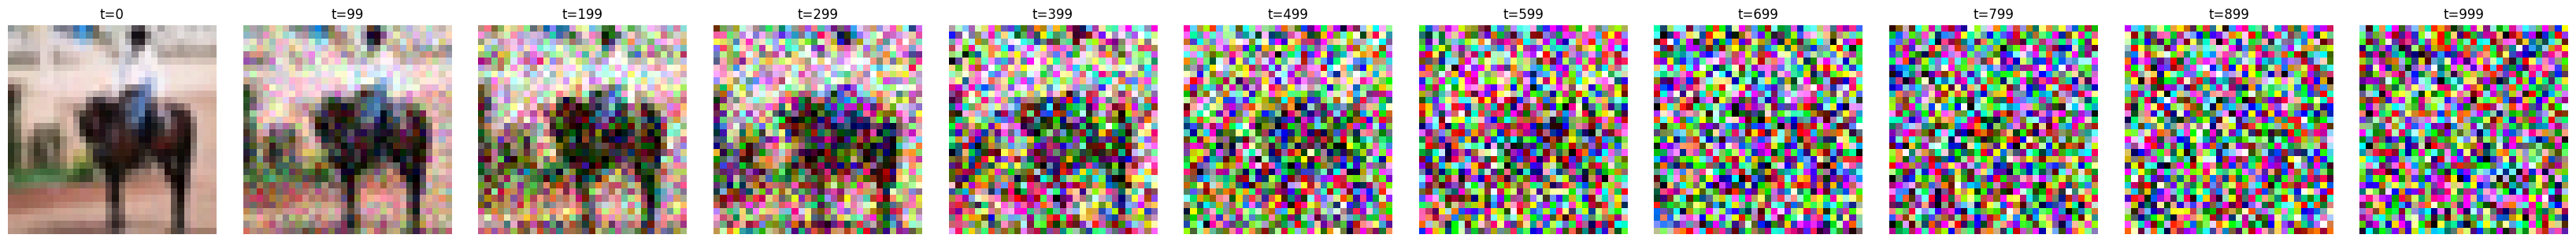

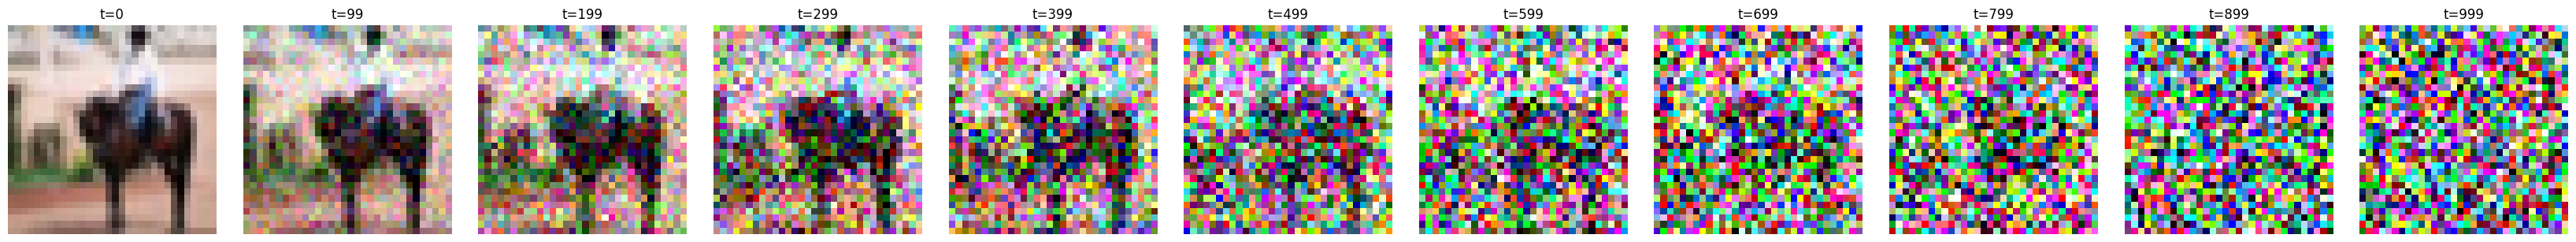

In [28]:
for schedule in [linear_schedule, quadratic_schedule, cosine_schedule]:
    beta,alpha,alpha_bar = schedule(T)
    viz_forward_process(x0_index=11,num_im=11)

<function linear_schedule at 0x0000021EC2666F20>
<function quadratic_schedule at 0x0000021EA2D12B60>
<function cosine_schedule at 0x0000021EA2D128E0>


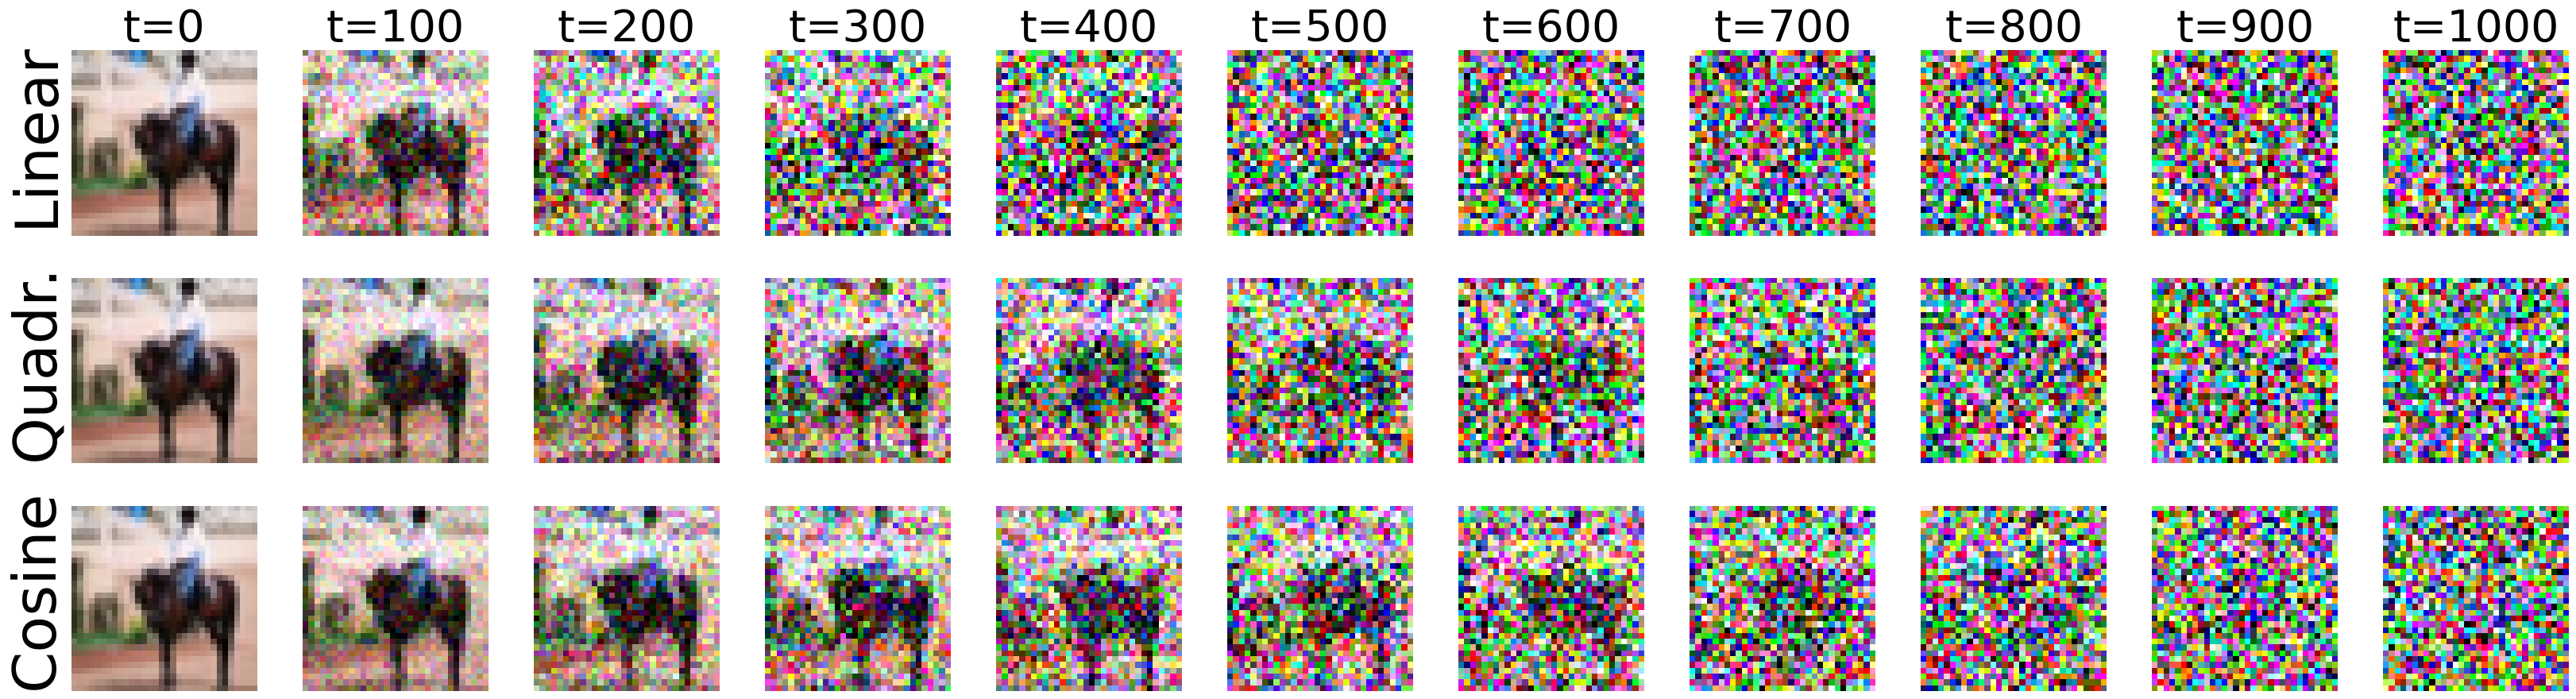

In [94]:
def viz_all_forward_processes_fixed(x0_index, schedules, schedule_names, num_im=9):
    global beta, alpha, alpha_bar
    ts = np.linspace(0, T - 1, num=num_im, dtype=int)
    x0 = training_data[x0_index][0].to(device)

    fig, axes = plt.subplots(len(schedules), num_im, figsize=(3 * num_im, 3 * len(schedules)))
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.1, hspace=0.2)

    for row, (schedule, name) in enumerate(zip(schedules, schedule_names)):
        print(schedule)
        beta, alpha, alpha_bar = schedule(T)
        for col, t in enumerate(ts):
            xt, eps = forward_diffusion(x0, t)
            if t == 0:
                xt = x0
            
            xt_image = xt.cpu().squeeze().permute(1, 2, 0)
            xt_image = torch.clamp(xt_image, min=-1.0, max=1.0)
            xt_image = (xt_image + 1.0) / 2.0
            
            ax = axes[row, col] if len(schedules) > 1 else axes[col]
            ax.imshow(xt_image)
            ax.axis('off')
            if row == 0:
                if t == 0:
                    ax.set_title(f"t=0", fontsize=40)
                else:
                    ax.set_title(f"t={ts[col]+1}", fontsize=40)

        # Add a subtitle for the row
        axes[row, 0].annotate(name, xy=(-0.03, 0.55), xycoords='axes fraction', fontsize=54, ha='right', va='center', rotation=90)

    plt.tight_layout()  # Adjust layout
    # plt.show()

# Example usage:
schedules = [linear_schedule, quadratic_schedule, cosine_schedule]
schedule_names = ["Linear", "Quadr.", "Cosine"]
viz_all_forward_processes_fixed(x0_index=11, schedules=schedules, schedule_names=schedule_names, num_im=11)
# plt.savefig('forward_schedules.pdf', format='pdf', dpi=300)
plt.show()

In [8]:
class PrintSize(torch.nn.Module):
    """Utility module to print current shape of a Tensor in Sequential, only at the first pass."""
    
    first = True
    
    def forward(self, x):
        if self.first:
            print(f"Size: {x.size()}")
            self.first = False
        return x

class ScoreNetwork0(torch.nn.Module):
    # takes an input image and time, returns the score function
    def __init__(self):
        super().__init__()
        # nch = 2
        chs = [32, 64, 128, 256, 256]
        self._convs = torch.nn.ModuleList([
            torch.nn.Sequential(
                torch.nn.Conv2d(IMAGE_SHAPE[0] + 1, chs[0], kernel_size=3, padding=1),  # (batch, ch, 28, 28)
                torch.nn.LogSigmoid(),  # (batch, 8, 28, 28)
                PrintSize()
            ),
            torch.nn.Sequential(
                torch.nn.MaxPool2d(kernel_size=2, stride=2),  # (batch, ch, 14, 14)
                torch.nn.Conv2d(chs[0], chs[1], kernel_size=3, padding=1),  # (batch, ch, 14, 14)
                torch.nn.LogSigmoid(),  # (batch, 16, 14, 14)
                PrintSize()
            ),
            torch.nn.Sequential(
                torch.nn.MaxPool2d(kernel_size=2, stride=2),  # (batch, ch, 7, 7)
                torch.nn.Conv2d(chs[1], chs[2], kernel_size=3, padding=1),  # (batch, ch, 7, 7)
                torch.nn.LogSigmoid(),  # (batch, 32, 7, 7)
                PrintSize()
            ),
            torch.nn.Sequential(
                torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0),  # (batch, ch, 4, 4)
                torch.nn.Conv2d(chs[2], chs[3], kernel_size=3, padding=1),  # (batch, ch, 4, 4)
                torch.nn.LogSigmoid(),  # (batch, 64, 4, 4)
                PrintSize()
            ),
            torch.nn.Sequential(
                torch.nn.MaxPool2d(kernel_size=2, stride=2),  # (batch, ch, 2, 2)
                torch.nn.Conv2d(chs[3], chs[4], kernel_size=3, padding=1),  # (batch, ch, 2, 2)
                torch.nn.LogSigmoid(),  # (batch, 64, 2, 2)
                PrintSize()
            ),
        ])
        self._tconvs = torch.nn.ModuleList([
            torch.nn.Sequential(
                # input is the output of convs[4]
                torch.nn.ConvTranspose2d(chs[4], chs[3], kernel_size=3, stride=2, padding=1, output_padding=1),  # (batch, 64, 4, 4)
                torch.nn.LogSigmoid(),
                PrintSize()
            ),
            torch.nn.Sequential(
                # input is the output from the above sequential concated with the output from convs[3]
                torch.nn.ConvTranspose2d(chs[3] * 2, chs[2], kernel_size=3, stride=2, padding=1, output_padding=1),  # (batch, 32, 7, 7)
                torch.nn.LogSigmoid(),
                PrintSize()
            ),
            torch.nn.Sequential(
                # input is the output from the above sequential concated with the output from convs[2]
                torch.nn.ConvTranspose2d(chs[2] * 2, chs[1], kernel_size=3, stride=2, padding=1, output_padding=1),  # (batch, chs[2], 14, 14)
                torch.nn.LogSigmoid(),
                PrintSize()
            ),
            torch.nn.Sequential(
                # input is the output from the above sequential concated with the output from convs[1]
                torch.nn.ConvTranspose2d(chs[1] * 2, chs[0], kernel_size=3, stride=2, padding=1, output_padding=1),  # (batch, chs[1], 28, 28)
                torch.nn.LogSigmoid(),
                PrintSize()
            ),
            torch.nn.Sequential(
                # input is the output from the above sequential concated with the output from convs[0]
                torch.nn.Conv2d(chs[0] * 2, chs[0], kernel_size=3, padding=1),  # (batch, chs[0], 28, 28)
                torch.nn.LogSigmoid(),
                torch.nn.Conv2d(chs[0], IMAGE_SHAPE[0], kernel_size=3, padding=1),  # (batch, 1, 28, 28)
                PrintSize()
            ),
        ])

    def forward(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        # x: (..., ch, H, W), t: (..., 1)
        # print(x.shape)
        # print(t.shape)
        tt = t[..., None, None].expand(*t.shape[:-1], 1, IMAGE_SHAPE[1], IMAGE_SHAPE[2])  # (..., 1, H, W)
        x2t = torch.cat((x, tt), dim=-3)
        # print(tt.shape)
        # print(x2t.shape)
        signal = x2t
        signals = []
        for i, conv in enumerate(self._convs):
            signal = conv(signal)
            # print(signal.shape)
            if i < len(self._convs) - 1:
                signals.append(signal)
        # print('--------------------')
        for i, tconv in enumerate(self._tconvs):
            if i == 0:
                signal = tconv(signal)
            else:
                # print(signal.shape)
                # print(signals[-i].shape)
                signal = torch.cat((signal, signals[-i]), dim=-3)
                signal = tconv(signal)
        signal = torch.reshape(signal, (*signal.shape[:-3], -1))  # (..., 1 * 28 * 28)
        
        # if signal.isnan().any():
            # print('nans!!!')
        return signal

# model = ScoreNetwork0().to(device)
# model

In [9]:
import os
os.getcwd()

'c:\\Users\\David\\OneDrive - Danmarks Tekniske Universitet\\02456_dl\\project\\02456-DDPM\\David'

In [10]:
from ddpm_unet import UNet
model = UNet().to(device)

In [11]:
# DDPM global variables
T = 1000
beta = torch.linspace(1e-4,0.02,T).to(device)
alpha = 1 - beta
alpha_bar = torch.cumprod(alpha, dim=0)

loss_fn = torch.nn.MSELoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)

# lr = 3e-4
lr = 2e-5
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

torch.Size([3, 32, 32])


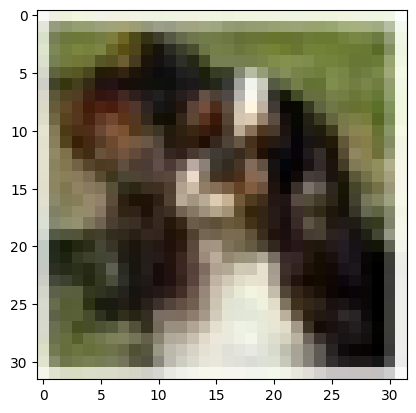

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8990492..1.8034835].


torch.Size([3, 32, 32])


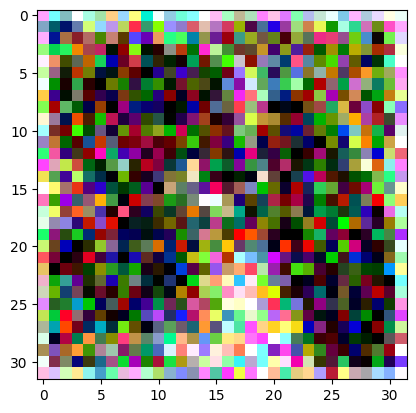

In [20]:
def forward_diffusion(x0, t):
    if not torch.is_tensor(t):
        t = torch.tensor(t)
    if t.dim() == 0:
        t = t.unsqueeze(0)
    
    t = t[...,None,None]
    eps = torch.normal(mean=0, std=torch.ones(x0.shape)).to(device)
    xt = alpha_bar[t]**0.5 * x0 + (1 - alpha_bar[t])**0.5 * eps
    return xt, eps

x0 = training_data[500][0].to(device)
print(x0.shape)
plt.imshow(np.squeeze(x0.permute(1,2,0).cpu()))
plt.show()

xt, eps = forward_diffusion(x0, T//10)
print(xt.shape)
plt.imshow(np.squeeze(xt.permute(1,2,0).cpu()))
plt.show()

In [13]:
asd = next(iter(train_dataloader))
asd[0].shape

torch.Size([64, 3, 32, 32])

In [14]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, _) in enumerate(dataloader):
        cur_batch_size = X.shape[0]
        X = X.to(device)
        t = torch.randint(low=0, high=T-1, size=(cur_batch_size,1), device=device)
        Xt, eps = forward_diffusion(X, t)

        # Compute prediction and loss
        pred = model(Xt, t.flatten())
        loss = loss_fn(pred.reshape(cur_batch_size, *IMAGE_SHAPE), eps)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # if batch % 100 == 0:
        if batch % 20 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            # loss, current = loss.item() / cur_batch_size, batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [22]:
 # Training
epochs = 3
for i in range(epochs):
    print(f"Epoch {i+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    # test_loop(test_dataloader, model, loss_fn)  # not done
print("Done!")

Epoch 1
-------------------------------
loss: 0.038497  [   64/50000]
loss: 0.037062  [ 1344/50000]
loss: 0.033626  [ 2624/50000]
loss: 0.033130  [ 3904/50000]
loss: 0.023121  [ 5184/50000]
loss: 0.028429  [ 6464/50000]
loss: 0.029282  [ 7744/50000]
loss: 0.041110  [ 9024/50000]
loss: 0.049448  [10304/50000]
loss: 0.025177  [11584/50000]
loss: 0.017843  [12864/50000]
loss: 0.045216  [14144/50000]
loss: 0.016137  [15424/50000]
loss: 0.036479  [16704/50000]
loss: 0.024416  [17984/50000]
loss: 0.029840  [19264/50000]
loss: 0.034076  [20544/50000]
loss: 0.027896  [21824/50000]
loss: 0.023199  [23104/50000]
loss: 0.030227  [24384/50000]
loss: 0.032023  [25664/50000]
loss: 0.035405  [26944/50000]
loss: 0.034068  [28224/50000]
loss: 0.025511  [29504/50000]
loss: 0.038134  [30784/50000]
loss: 0.026299  [32064/50000]
loss: 0.040365  [33344/50000]
loss: 0.043152  [34624/50000]
loss: 0.023894  [35904/50000]
loss: 0.034681  [37184/50000]
loss: 0.018572  [38464/50000]
loss: 0.026174  [39744/50000]


In [17]:
from IPython.display import clear_output
def sampling():
    with torch.no_grad():
        sig = beta**0.5
        x = torch.normal(mean=0, std=torch.ones((1,*IMAGE_SHAPE))).to(device)
        for t in range(T-1, -1, -1):
            if t > 0:
                z = torch.normal(mean=0, std=torch.ones(*IMAGE_SHAPE)).to(device)
            else:
                z = torch.zeros(*IMAGE_SHAPE).to(device)
            t = torch.tensor([t]).to(device)
            eps_theta = model(x, t.flatten()).reshape(*IMAGE_SHAPE)
            x = 1/alpha[t]**0.5 * (x - (1-alpha[t])/(1-alpha_bar[t])**0.5 * eps_theta) + \
                    sig[t] * z
            
            if (t % 100) == 0:
                clear_output(wait=True)
                xt_image = x.cpu().squeeze().permute(1, 2, 0)
                xt_image = torch.clamp(xt_image, min=-1.0, max=1.0)
                xt_image = (xt_image + 1.0) / 2.0
                plt.imshow(xt_image)
                plt.show()
    
    return x.detach()

In [ ]:
model.eval()
x_sample = sampling()
def normalize(im):
    xt_image = im.cpu().squeeze().permute(1, 2, 0)
    xt_image = torch.clamp(xt_image, min=-1.0, max=1.0)
    xt_image = (xt_image + 1.0) / 2.0
    return xt_image